In [1]:
from torchvision.datasets.folder import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from statistics import mean
import impaintingLib as imp

import torchvision
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def allDataset():
    datasets = []
    datasets.append(imp.data.getDataset("./data/utk",factorResize=2,doShuffle=True,doCrop=False))
    datasets.append(imp.data.getDataset("./data/flickr",factorResize=2,doShuffle=True,doCrop=False))
    datasets.append(imp.data.getDataset("data/lfw",factorResize=2,doShuffle=True))
    datasets.append(imp.data.getDataset("./data/celeba",factorResize=2,doShuffle=True))
    return torch.utils.data.ConcatDataset(datasets)

In [8]:
from torch.utils.tensorboard import SummaryWriter

def train_inpainting_segmented_keypoints(net, optimizer, loader, alter, runName="bigRun", scale_factor=4, epochs=5, simplify_seg=True, show_images=True):
    
    net.train()
    accum_iter = 100 
    lrs = []
    current_lr = optimizer.param_groups[0]["lr"]
    lambda1 = lambda epoch: 0.67 ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    
    t1 = tqdm(range(epochs), desc=f"Training progress", colour="#00ff00")
    
    for epoch in t1:
        running_loss = []
        t2 = tqdm(loader, leave=False, colour="#005500") 

        for batch_idx,(x,_) in enumerate(t2):
            x = x.to(device)
            x = imp.data.randomTransfo(x)
            x_prime = alter(x)
            
            with torch.set_grad_enabled(True):
                segmented = imp.components.get_segmentation(x, simplify=simplify_seg, scale_factor=scale_factor)
                x_input = torch.cat((x_prime, segmented),dim=1)
                keypointLayer = imp.components.getKeypoints(x)
                x_input = torch.cat((x_input, keypointLayer),dim=1)

                outputs = net(x_input)

                loss = 1e-5
                loss += torch.nn.L1Loss()(outputs, x)
                loss += imp.loss.perceptualVGG(outputs, x)
                loss += imp.loss.totalVariation(outputs, x)
                loss /= accum_iter

                running_loss.append(loss.item())
                loss.backward()

                if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(t2)):
                    optimizer.step()
                    optimizer.zero_grad()
                
                t2.set_description(f'Epoch {epoch}, training loss: {mean(running_loss)}, LR : {current_lr}, epoch {epoch + 1}/{epochs}')
                
        current_lr = optimizer.param_groups[0]["lr"]
        lrs.append(current_lr)
        scheduler.step()
                
        t1.set_description(f'Epoch {epoch + 1}/{epochs}, LR : {current_lr}')
            
        if show_images:
            imp.utils.plot_img(x[:8])
            imp.utils.plot_img(x_prime[:8])
            imp.utils.plot_img(segmented[:8])
            imp.utils.plot_img(torch.clip(outputs[:8], 0, 1))
            imp.utils.plot_img(keypointLayer[:8])
            
        writer = SummaryWriter("runs/" + runName)
        writer.add_scalar("training loss", mean(running_loss), epoch)
        writer.add_image("Original",make_grid(x[:8]))
        writer.add_image("Predict",make_grid(torch.clip(outputs[:8], 0, 1)))
        writer.close()
        
        torch.save(net.state_dict(),"./modelSave/train/{}_{}".format(runName,epoch))

292149 <torch.utils.data.dataset.ConcatDataset object at 0x7ff81934e910>
20 <torch.utils.data.dataloader.DataLoader object at 0x7ff81934ed30>


Training progress:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

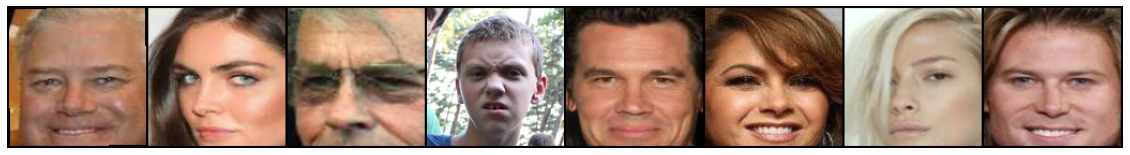

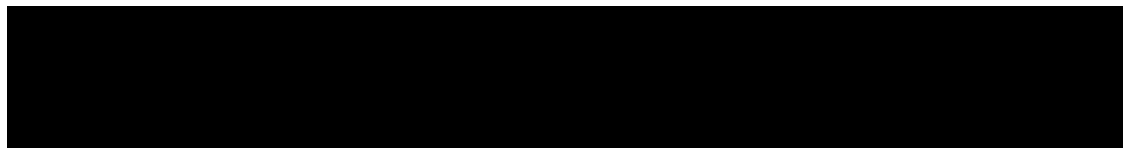

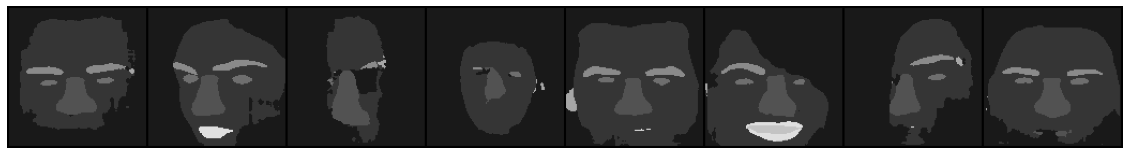

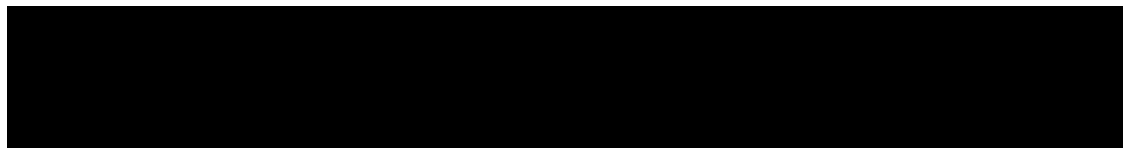

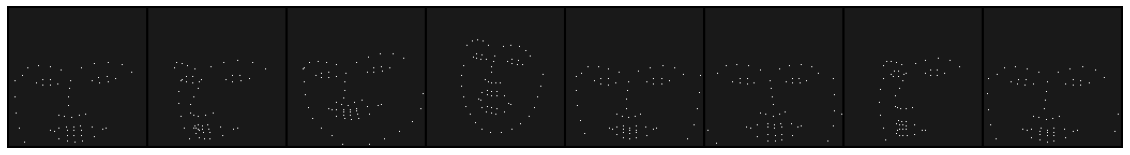

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
factorResize = 2
scale_factor = 2
batch_size = 32
runName = "bestMore"

model = imp.model.UNet(5, netType="partial").to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
alter = imp.mask.Alter(resize=factorResize,seed=0,test=False).fullMask # squareMask irregularMask fullMask

dataset = allDataset()
print(len(dataset))
dataset,_ = torch.utils.data.random_split(dataset, [640, len(dataset)-640])
trainloader = DataLoader(dataset, num_workers=2, batch_size=batch_size, shuffle=True)
print(len(trainloader))

#model.load_state_dict(torch.load("./modelSave/impainter"))
train_inpainting_segmented_keypoints(model, optimizer, trainloader, alter, runName=runName, scale_factor=scale_factor, simplify_seg=True, epochs=30)